This notebook contains a simple example of applying DMD on publicly available functional MRI data.

In [38]:
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets, plotting, surface
import nilearn
import numpy as np
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")

/tmp/ipykernel_32040/3545721401.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


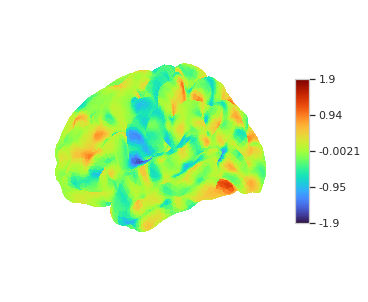

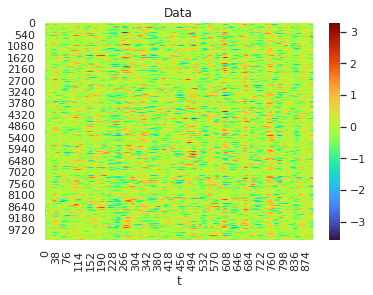

In [39]:
# Load some test data using Nilearn and show it

dataset = datasets.fetch_surf_nki_enhanced(n_subjects=1)
data = surface.load_surf_data(dataset["func_left"][0])  # fMRI time series
n, m = data.shape

fsaverage = nilearn.datasets.fetch_surf_fsaverage()  # surface mesh

fig = plotting.plot_surf(
    fsaverage.pial_left, data[:, 0], hemi="left", colorbar=True, cmap="turbo",
)
fig.show()

fig = plt.figure()
sns.heatmap(data, cmap="turbo")
plt.title("Data")
plt.xlabel("t")
plt.show()

In [40]:
# Organize data in X and X'

X = data[:, 0:-1]
X_prime = data[:, 1::]
if np.linalg.cond(X) > 1e15:
    print(f"Matrix is ill-conditioned! (cond = {np.linalg.cond(X)})")

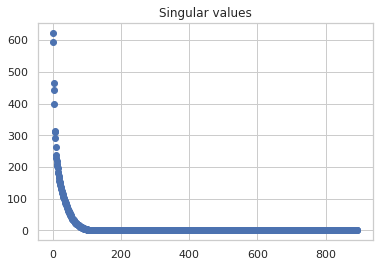

In [41]:
# Perform SVD

u, s, vh = np.linalg.svd(X, full_matrices=False)

plt.scatter(np.arange(len(s)), s)
plt.title("Singular values")
plt.show()

In [42]:
# Truncate SVD results

r = 100

u = u[:, 0:r]
s = s[0:r]
vh = vh[0:r, :]

A_tilde = u.conj().T @ X_prime @ vh.conj().T @ np.linalg.inv(np.diag(s))
evals, W = np.linalg.eig(A_tilde)
evals_arr = np.copy(evals)
evals = np.diag(evals)  # evals is now equal to Λ
phi = X_prime @ vh.conj().T @ np.linalg.inv(np.diag(s)) @ W

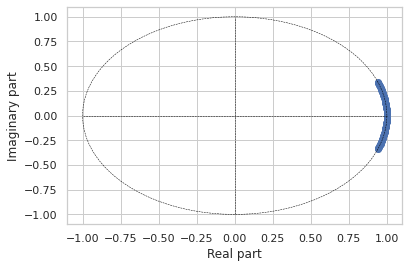

In [45]:
# Show mode eigenvalues

plt.scatter(evals_arr.real, evals_arr.imag)
angles = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(angles), np.sin(angles), ls="--", color="black", lw=0.5)
plt.plot([-1, 1], [0, 0], ls="--", color="black", lw=0.5)
plt.plot([0, 0], [-1, 1], ls="--", color="black", lw=0.5)
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.show()

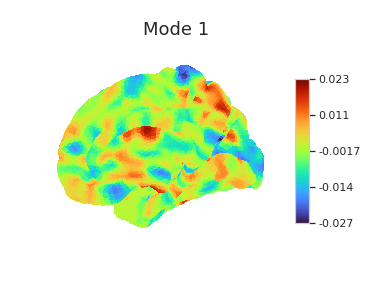

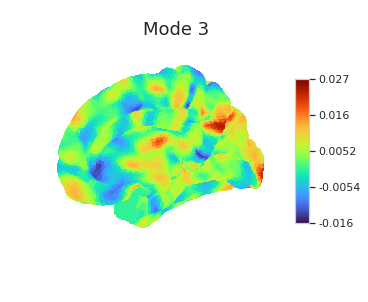

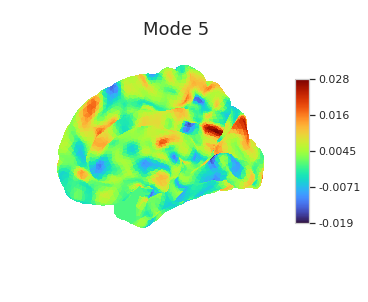

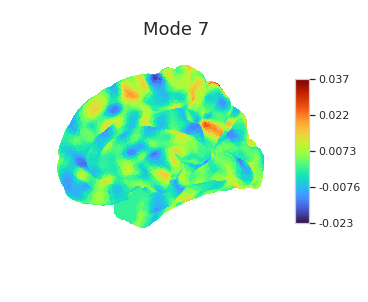

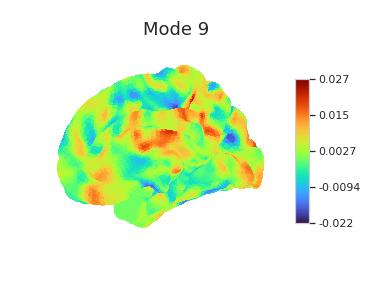

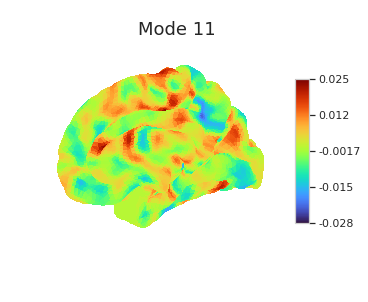

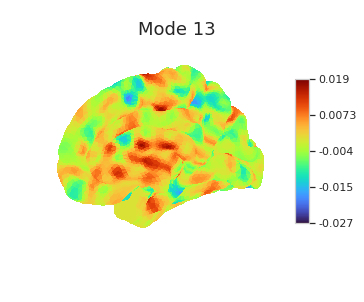

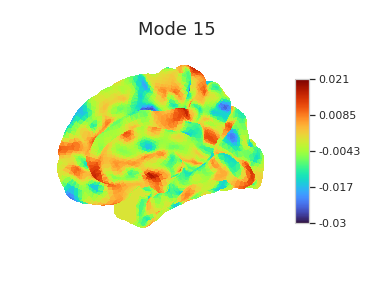

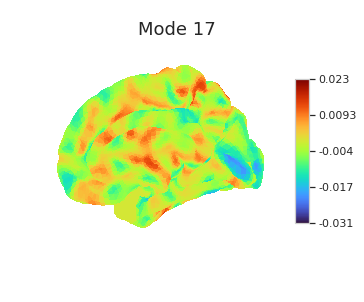

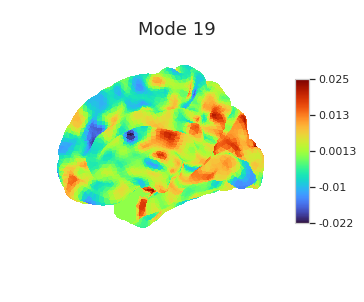

In [37]:
# Visualize the first 10 odd modes

modes = phi.real

for i in range(0, 20, 2):
    fig = plotting.plot_surf(
        fsaverage.pial_right,
        modes[:, i],
        hemi="left",
        colorbar=True,
        cmap="turbo",
        title=f"Mode {i + 1}",
    )
    fig.show()

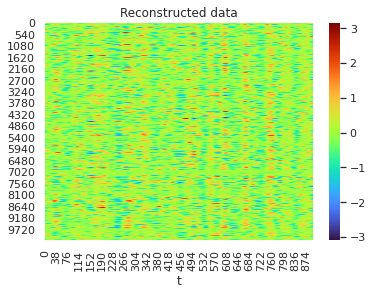

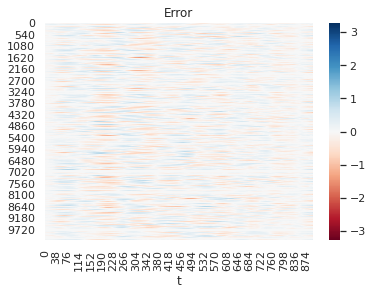

In [44]:
# Reconstruct timeseries and show error

X_pred = np.zeros((m, n), dtype=complex)
b = np.linalg.pinv(phi) @ X[:, 0]
X_pred[0] = data[:, 0]
for i in range(1, m):
    X_pred[i] = phi @ evals ** i @ b

fig = plt.figure()
sns.heatmap(X_pred.T.real, cmap="turbo")
plt.xlabel("t")
plt.title("Reconstructed data")
plt.show()

fig = plt.figure()
sns.heatmap(data - X_pred.T.real, cmap="RdBu", vmin=-np.max(data), vmax=np.max(data))
plt.xlabel("t")
plt.title("Error")
plt.show()